We install the latest development version here to test new features. 

In [1]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

'06Dec2020 14:02'

In [2]:
import covsirphy as cs
# cs.__version__
cs.get_version()

'CovsirPhy v2.12.0-iota.new.362.366.367.fix.360.373.solving.357.359'

Here all required liberaries are impoted for further implements. 

In [3]:
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import functools
from IPython.display import display, Markdown
import math
import os
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import pandas as pd
import dask.dataframe as dd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
import scipy as sci
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import sympy as sym

For dataset we use COVID-19 source data from ourworldindata.org like for previous model. Also there is another dataset which was retrieved from https://covid19datahub.io/. 

In [4]:
# Create instance of covsirphy.DataLoader class
data_loader = cs.DataLoader(directory="kaggle/input")
# Retrieve the dataset of the number of COVID-19 cases
# Kaggle platform: covid19dh.csv will be saved in /output/kaggle/working/input
# Local env: covid19dg.cv will be saved in /input
jhu_data = data_loader.jhu()


Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/

Please set verbose=2 to see the detailed citation list.




Cleaned dataset of all countries was saved in jhu_data and we can get the cleaned dataset as a pandas.DataFrame.

In [5]:
jhu_data.cleaned().tail(10)


,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
351902,2020-11-27,Colombia,Vichada,888,10,11,867
351903,2020-11-28,Colombia,Vichada,896,13,12,871
351904,2020-11-29,Colombia,Vichada,898,7,12,879
351905,2020-11-30,Colombia,Vichada,919,27,12,880
351906,2020-12-01,Colombia,Vichada,923,10,12,901
351907,2020-12-02,Colombia,Vichada,930,16,12,902
351908,2020-12-03,Colombia,Vichada,931,9,12,910
351909,2020-12-04,Colombia,Vichada,931,7,12,912
351910,2020-12-05,Colombia,Vichada,933,8,12,913
351911,2020-12-06,Colombia,Vichada,933,8,12,913


We can subset records with country name. Now we exclude cleaned dataset of Ukraine from all countries dataset.

In [6]:
jhu_data.subset("Ukraine", province=None).tail()

,Date,Confirmed,Infected,Fatal,Recovered
256,2020-12-02,778560,380459,13140,384961
257,2020-12-03,793372,379227,13394,400751
258,2020-12-04,808828,380840,13641,414347
259,2020-12-05,822985,379653,13877,429455
260,2020-12-06,822985,379653,13877,429455


For calculating the passed days from the first case of COVID-19, we can run the mentioned codes and the result would be as follows:

In [7]:
df = jhu_data.cleaned()
jhu_first_date, jhu_last_date = df["Date"].min(), df["Date"].max()
jhu_elapsed = (jhu_last_date - jhu_first_date).days
print(f"{jhu_elapsed} days have passed from the date of the first record.")

340 days have passed from the date of the first record.


We can replace COVID-19 Data Hub's records in Ukraine with UkraineData1.csv as our preferred dataset. 

In [8]:
# Data cleaning of Japan-specific dataset
ukre_data = cs.CountryData("UkraineData1.csv", country="Ukraine")
# Set variables because the raw dataset does not have the same column names as that of jhu_data
ukre_data.set_variables(
    date="date", confirmed="new_cases", fatal="new_deaths", recovered="recovered", province=None
)
# Note: when we do not have this CSV file registered in Kaggle, we can download with
# ukre_data = data_loader.japan()

Now we exclude the cleaned dataset of Ukraine from our specified dataset. 

In [9]:
# Show cleaned dataset
ukre_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
250,2020-11-15,Ukraine,-,12524,-239531,191,251864
251,2020-11-16,Ukraine,-,10681,-244067,95,254653
252,2020-11-17,Ukraine,-,9832,-252098,94,261836
253,2020-11-18,Ukraine,-,11968,-258460,159,270269
254,2020-11-19,Ukraine,-,12496,-265950,256,278190


We need population values to calculate the number of "susceptible" cases. 

In [10]:
# We can use a method of cs.DataLoader()
population_data = data_loader.population()
# Show cleaned dataset
population_data.cleaned().tail(10)

,ISO3,Country,Province,Date,Population
296660,COL,Colombia,Vichada,2020-11-27,107808
296661,COL,Colombia,Vichada,2020-11-28,107808
296662,COL,Colombia,Vichada,2020-11-29,107808
296663,COL,Colombia,Vichada,2020-11-30,107808
296664,COL,Colombia,Vichada,2020-12-01,107808
296665,COL,Colombia,Vichada,2020-12-02,107808
296666,COL,Colombia,Vichada,2020-12-03,107808
296667,COL,Colombia,Vichada,2020-12-04,107808
296668,COL,Colombia,Vichada,2020-12-05,107808
296669,COL,Colombia,Vichada,2020-12-06,107808


Now we illustrate the trend of COVID-19 confirmed cases and recovered cases based on COVID-19 dataset and population dataset using .Scenario

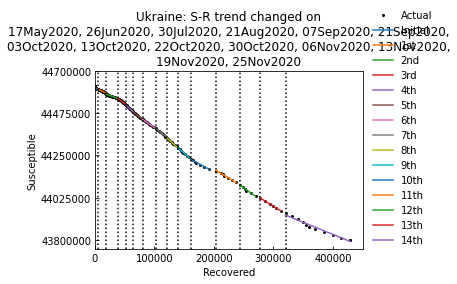

In [11]:
ita_scenario = cs.Scenario(jhu_data, population_data, "Ukraine")
_ = ita_scenario.trend()

We use population pyramid to estimate the number of days go out in average.

In [12]:
pyramid_csv_list = list()
for dirname, _, filenames in os.walk("population-pyramid-2019-2020"):
    for filename in filenames:
        name = os.path.join(dirname, filename)
        df = pd.read_csv(name)
        df["Country"], df["Year"], _ = filename.replace(".", "-").split("-")
        pyramid_csv_list.append(df)
pyramid_raw = pd.concat(pyramid_csv_list, sort=True)
pyramid_raw.head(10)

,Age,Country,F,M,Year
0,0-4,Canada,965981,1013876,2019
1,5-9,Canada,967470,1012761,2019
2,10-14,Canada,961187,1006817,2019
3,15-19,Canada,978597,1027473,2019
4,20-24,Canada,1176141,1231211,2019
5,25-29,Canada,1331426,1371604,2019
6,30-34,Canada,1296437,1296540,2019
7,35-39,Canada,1311383,1300549,2019
8,40-44,Canada,1219488,1205213,2019
9,45-49,Canada,1187043,1185947,2019


ist of countries including Ukraine can be shown.

In [13]:
pyramid_raw["Country"].unique()

array(['Canada', 'China', 'France', 'Germany', 'India', 'Iran', 'Italy',
       'Japan', 'Spain', 'Ukraine', 'United Kingdom',
       'United States of America'], dtype=object)

We also add global data manually to our dataset to have the column “Global” in the population table. 

In [14]:
df = pyramid_raw.copy()
df["Country"] = df["Country"].replace(
    {
        "United States of America": "US",
        "United Kingdom": "UK",
    }
)
# Global (WORLD)
_male = [
    349432556, 342927576, 331497486, 316642222, 308286775, 306059387, 309236984,
    276447037, 249389688, 241232876, 222609691, 192215395, 157180267, 128939392,
    87185982, 54754941, 33648953, 15756942, 5327866, 1077791, 124144
]
_female = [
    328509234, 321511867, 309769906, 295553758, 289100903, 288632766, 296293748,
    268371754, 244399176, 238133281, 223162982, 195633743, 164961323, 140704320,
    101491347, 69026831, 48281201, 26429329, 11352182, 3055845, 449279
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Global",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)

df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Arrange
df["Population"] = df["F"] + df["M"]
df = df.pivot_table(
    index="Age", columns=["Country"], values="Population", aggfunc="last"
)
df = df.astype(np.int64).reset_index().rename({"Age": "Age_bin"}, axis=1)
series = df["Age_bin"].str.replace("+", "-122")
df[["Age_first", "Age_last"]] = series.str.split("-", expand=True).astype(np.int64)
df = df.drop("Age_bin", axis=1)
series = df["Age_last"]
df = df.apply(lambda x: x[:-2] / (x[-1] - x[-2] + 1), axis=1)
df["Age"] = series
df = pd.merge(df, pd.DataFrame({"Age": np.arange(0, 123, 1)}), on="Age", how="right", sort=True)
df = df.fillna(method="bfill").astype(np.int64)
df = df.set_index("Age")
pyramid_df = df.copy()
pyramid_df.loc[24:32]

,Canada,China,France,Germany,Global,India,Iran,Italy,Japan,Spain,UK,US,Ukraine
Age,,,,,,,,,,,,,
24,481470,17715284,739703,910269,119477535,24359467,1145239,591064,1206093,453011,824053,4487193,429209
25,540606,20862923,743386,974062,118938430,23336824,1431838,635981,1247523,477414,902069,4748619,550488
26,540606,20862923,743386,974062,118938430,23336824,1431838,635981,1247523,477414,902069,4748619,550488
27,540606,20862923,743386,974062,118938430,23336824,1431838,635981,1247523,477414,902069,4748619,550488
28,540606,20862923,743386,974062,118938430,23336824,1431838,635981,1247523,477414,902069,4748619,550488
29,540606,20862923,743386,974062,118938430,23336824,1431838,635981,1247523,477414,902069,4748619,550488
30,518595,25443044,794706,1088730,121106146,22212195,1723272,677981,1390715,543276,936727,4540684,716966
31,518595,25443044,794706,1088730,121106146,22212195,1723272,677981,1390715,543276,936727,4540684,716966
32,518595,25443044,794706,1088730,121106146,22212195,1723272,677981,1390715,543276,936727,4540684,716966


Now we conduct a table which shows columns such as different ranges of ages and different periods of life for the population

In [15]:
_period_of_life_list = [
    "nursery", "nursery school", "elementary school", "middle school",
    "high school", "university/work", "work", "work", "work", "work",
    "retired", "retired", "retired"
]
df = pd.DataFrame(
    {
        "Age_first": [0, 3, 6, 11, 14, 19, 26, 36, 46, 56, 66, 76, 86],
        "Age_last": [2, 5, 10, 13, 18, 25, 35, 45, 55, 65, 75, 85, 95],
        "Period_of_life": _period_of_life_list,
        "Days": [3, 5, 6, 6, 7, 7, 6, 5, 5, 5, 4, 3, 2]
    }
)
# Adjustment by author
df["Types"] = df["Period_of_life"].replace(
    {
        "nursery": "school",
        "nursery school": "school",
        "elementary school": "school",
        "middle school": "school",
        "high school": "school",
        "university/work": "school/work"
    }
)
df["School"] = df[["Types", "Days"]].apply(lambda x: x[1] if "school" in x[0] else 0, axis=1)
df["Office"] = df[["Types", "Days"]].apply(lambda x: x[1] if "work" in x[0] else 0, axis=1)
df["Others"] = df["Days"] - df[["School", "Office"]].sum(axis=1)
df.loc[df["Others"] < 0, "Others"] = 0
df.loc[df.index[1:5], "School"] -= 1
df.loc[df.index[1:5], "Others"] += 1
df.loc[df.index[5], ["School", "Office", "Others"]] = [3, 3, 1]
df[["School", "Office", "Others"]] = df[["Days", "School", "Office", "Others"]].apply(
    lambda x: x[1:] / sum(x[1:]) * x[0], axis=1
).astype(np.int64)
df.loc[df.index[6:10], "Others"] += 1
df = df.drop(["Days", "Types"], axis=1)
# Show dataset
_out_df = df.copy()
_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others
0,0,2,nursery,3,0,0
1,3,5,nursery school,4,0,1
2,6,10,elementary school,5,0,1
3,11,13,middle school,5,0,1
4,14,18,high school,6,0,1
5,19,25,university/work,3,3,1
6,26,35,work,0,6,1
7,36,45,work,0,5,1
8,46,55,work,0,5,1
9,56,65,work,0,5,1


For each country, population pyramid data will be combined into this table. The columns with country names are the portion of the total population. 

In [16]:
df = pyramid_df.cumsum()
countries = df.columns[:]
df = pd.merge(_out_df, df, left_on="Age_last", right_on="Age", how="left")
_first = df.loc[df.index[0], countries]
df[countries] = df[countries].diff()
df.loc[df.index[0], countries] = _first
df[countries] = df[countries].apply(lambda x: x / x.sum(), axis=0)
out_df = df.copy()
out_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Canada,China,France,Germany,Global,India,Iran,Italy,Japan,Spain,UK,US,Ukraine
0,0,2,nursery,3,0,0,0.031811,0.035600,0.033901,0.028711,0.052210,0.051289,0.054879,0.023674,0.023292,0.025943,0.035174,0.035813,0.029017
1,3,5,nursery school,4,0,1,0.031813,0.035809,0.034727,0.028115,0.051864,0.051752,0.052977,0.024795,0.024166,0.027265,0.035658,0.036229,0.030672
2,6,10,elementary school,5,0,1,0.052963,0.059984,0.060787,0.045016,0.084689,0.088830,0.080195,0.045552,0.043395,0.050480,0.060363,0.062293,0.056309
3,11,13,middle school,5,0,1,0.031621,0.035035,0.036844,0.027347,0.049386,0.055770,0.043894,0.028506,0.026526,0.031812,0.034583,0.038632,0.032996
4,14,18,high school,6,0,1,0.053517,0.057906,0.059948,0.048961,0.079324,0.092191,0.067379,0.047546,0.045251,0.048522,0.055262,0.064638,0.047233
5,19,25,university/work,3,3,1,0.089688,0.087912,0.080317,0.076269,0.107659,0.124634,0.099528,0.068986,0.066696,0.068295,0.085452,0.095708,0.070750
6,26,35,work,0,6,1,0.141335,0.160417,0.119402,0.124868,0.152774,0.164456,0.192333,0.110560,0.106875,0.113973,0.136443,0.139912,0.148973
7,36,45,work,0,5,1,0.133597,0.140662,0.124751,0.123987,0.131630,0.135250,0.163720,0.137011,0.134815,0.162583,0.129938,0.125441,0.156723
8,46,55,work,0,5,1,0.132237,0.166102,0.134609,0.150438,0.116396,0.103354,0.110998,0.161104,0.142129,0.158071,0.134289,0.125788,0.134502
9,56,65,work,0,5,1,0.137679,0.116123,0.124850,0.143657,0.088096,0.074217,0.075731,0.135972,0.123395,0.128555,0.119465,0.125640,0.135738


Now we are capable to calculate the amount of people who went out during the COVID-19 time compared to their age. This dataset can also be cleaned and specified for Ukraine. 

In [17]:
def go_out(country, out_df=out_df):
    """
    Return the estimated number of days people usually go out.
    @country <str>: coutry name
    @out_df <pd.DataFrame>: template dataframe
    """
    df = out_df.copy()
    try:
        series = df[country]
    except KeyError:
        raise KeyError(f"Population pyramid data of {country} is not defined!")
    df = df.iloc[:, :6]
    df["Portion"] = series
    return df

In [18]:
go_out("Ukraine")

,Age_first,Age_last,Period_of_life,School,Office,Others,Portion
0,0,2,nursery,3,0,0,0.029017
1,3,5,nursery school,4,0,1,0.030672
2,6,10,elementary school,5,0,1,0.056309
3,11,13,middle school,5,0,1,0.032996
4,14,18,high school,6,0,1,0.047233
5,19,25,university/work,3,3,1,0.070750
6,26,35,work,0,6,1,0.148973
7,36,45,work,0,5,1,0.156723
8,46,55,work,0,5,1,0.134502
9,56,65,work,0,5,1,0.135738


Line list in clinical trials is a list of many case reports. Here also a table of content is excludable with columns

In [19]:
linelist_raw = pd.read_csv("COVID19_line_list_data.csv")

In [20]:
df = linelist_raw.loc[:, ~linelist_raw.columns.str.startswith("Unnamed:")]
df = df.drop(["id", "case_in_country", "summary", "source", "link"], axis=1)
# Date
case_date_dict = {
    "reporting date": "Confirmed_date",
    "exposure_start": "Exposed_date",
    "exposure_end": "Quarantined_date",
    "hosp_visit_date": "Hospitalized_date",
    "symptom_onset": "Onset_date",
    "death": "Deaths_date",
    "recovered": "Recovered_date"    
}
df["death"] = df["death"].replace({"0": "", "1": ""})
df["recovered"] = df["recovered"].replace({"0": "", "1": "", "12/30/1899": "12/30/2019"})
for (col, _) in case_date_dict.items():
    df[col] = pd.to_datetime(df[col])
df = df.rename(case_date_dict, axis=1)
# Location
df["Country"] = df["country"].fillna("-")
df["Province"] = df["location"].fillna("-")
df["Province"] = df[["Country", "Province"]].apply(lambda x: "-" if x[0] == x[1] else x[1], axis=1)
# Personal
df["Gender"] = df["gender"].fillna("-").str.capitalize()
df["Age"] = df["age"].fillna(df["age"].median()).astype(np.int64) ## Fill in NA with median
df["From_Wuhan"] = df["from Wuhan"]
df["To_Wuhan"] = df["visiting Wuhan"]
# Medical
df["Events"] = df["symptom"].fillna("-")
# Order of columns
linelist_df = df.loc[
    :,
    [
        "Country", "Province",
        "Exposed_date", "Onset_date", "Hospitalized_date", "Confirmed_date", "Quarantined_date", "Deaths_date", "Recovered_date",
        "Events",
        "Gender", "Age", "From_Wuhan", "To_Wuhan"
    ]
]
linelist_df.tail(15)

,Country,Province,Exposed_date,Onset_date,Hospitalized_date,Confirmed_date,Quarantined_date,Deaths_date,Recovered_date,Events,Gender,Age,From_Wuhan,To_Wuhan
1070,Bahrain,-,NaT,NaT,NaT,2020-02-25,NaT,NaT,NaT,-,Female,51,0.0,0
1071,Bahrain,-,NaT,NaT,NaT,2020-02-25,NaT,NaT,NaT,-,Female,51,0.0,0
1072,Bahrain,-,NaT,NaT,NaT,2020-02-25,NaT,NaT,NaT,-,Female,51,0.0,0
1073,Bahrain,-,NaT,NaT,NaT,2020-02-25,NaT,NaT,NaT,-,Female,51,0.0,0
1074,Bahrain,-,NaT,NaT,NaT,2020-02-25,NaT,NaT,NaT,-,Male,51,0.0,0
1075,Bahrain,-,NaT,NaT,NaT,2020-02-25,NaT,NaT,NaT,-,Male,51,0.0,0
1076,Bahrain,-,NaT,NaT,NaT,2020-02-25,NaT,NaT,NaT,-,Male,51,0.0,0
1077,Bahrain,-,NaT,NaT,NaT,2020-02-25,NaT,NaT,NaT,-,Female,51,0.0,0
1078,Bahrain,-,NaT,NaT,NaT,2020-02-25,NaT,NaT,NaT,-,Female,51,0.0,0
1079,Austria,Innsbruck,NaT,NaT,NaT,2020-02-25,NaT,NaT,NaT,-,-,24,0.0,0


Now we investigate the exposed date and onset date and make a cleaned data out of it. 

In [21]:
# linelist_df.info()
# linelist_df.describe(include="all").fillna("-")
period_df = linelist_df.loc[:, ["Exposed_date", "Onset_date", "Confirmed_date"]]
period_df["Latent [min]"] = (period_df["Onset_date"] - period_df["Exposed_date"]).dt.total_seconds() / 60
period_df["Waiting [min]"] = (period_df["Confirmed_date"] - period_df["Onset_date"]).dt.total_seconds() / 60
period_df["Latent [day]"] = period_df["Latent [min]"] / 60 / 24
period_df["Waiting [day]"] = period_df["Waiting [min]"] / 60 / 24
period_df["Latent + Waiting [day]"] = period_df["Latent [day]"] + period_df["Waiting [day]"]
period_df.dropna(axis=0).tail()

,Exposed_date,Onset_date,Confirmed_date,Latent [min],Waiting [min],Latent [day],Waiting [day],Latent + Waiting [day]
948,2020-01-25,2020-02-24,2020-02-24,43200.0,0.0,30.0,0.0,30.0
949,2020-01-25,2020-02-04,2020-02-24,14400.0,28800.0,10.0,20.0,30.0
957,2020-01-25,2020-02-12,2020-02-26,25920.0,20160.0,18.0,14.0,32.0
958,2020-01-25,2020-02-17,2020-02-26,33120.0,12960.0,23.0,9.0,32.0
1084,2020-02-15,2020-02-17,2020-02-25,2880.0,11520.0,2.0,8.0,10.0


To make a diagram we use columns of table above such as: “Latent [day]”, “waiting [day]” and concacnate them.

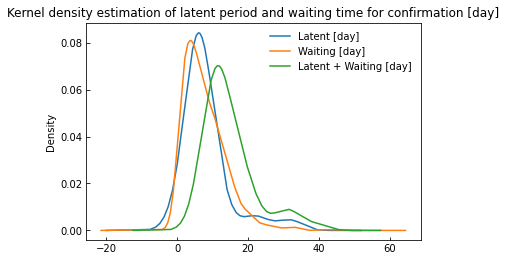

,count,mean,std,min,25%,50%,75%,max
Latent [day],83.0,8.180723,6.786185,-2.0,4.0,6.0,9.0,34.0
Waiting [day],563.0,7.682060,5.890473,0.0,3.0,6.0,11.0,43.0
Latent + Waiting [day],83.0,14.819277,7.305435,5.0,10.0,13.0,17.5,40.0


In [22]:
cols = ["Latent [day]", "Waiting [day]", "Latent + Waiting [day]"]
period_df[cols].plot.kde()
plt.title("Kernel density estimation of latent period and waiting time for confirmation [day]")
plt.show()
period_df[cols].describe().T

Also, To understand why the parameters were changed in Italy, we will use this dataset in Italy scenario analysis. 

In [23]:
ita_action_raw = pd.read_excel(
    "Dataset_Italy_COVID_19.xlsx",
    sheet_name="Foglio1"
)
# ita_action_raw.head()

In [24]:
df = ita_action_raw.copy()
df = df.drop(["Country", "Village", "link"], axis=1)
df.columns = [col.capitalize().replace(" ", "_") for col in df.columns]
df["Start_date"] = pd.to_datetime(df["Start_date"])
df["End_date"] = pd.to_datetime(df["End_date"])
df["Region"] = df["Region"].fillna("-")
df["Number_of_people"] = df["Number_of_people"].fillna(-1)
ita_action_df = df.copy()
ita_action_df.tail()

,Region,Start_date,End_date,Action,Detail,Number_of_people
7,"Emilia Romagna,Friuli Venezia Giulia, Lombardi...",2020-03-07,2020-03-07,more containment and management the Italian in...,prohibit any movement in Lombardy and in fourt...,-1
8,-,2020-03-09,2020-05-04,lockdown,people must stay at home and go out only for f...,60483973
9,-,2020-03-19,NaT,Medicine sperimentation,"testing began on the drug Tocilizumab, a drug ...",330
10,-,2020-03-20,NaT,task force,create a task force of doctors from all over I...,-1
11,-,2020-04-14,NaT,open some businesses,"Reopening of some production activities, newsa...",-1


Here we will visualize the total value of the number of cases in all countries including columns.

In [25]:
data_cols = ["Infected", "Fatal", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]

In [26]:
total_df = jhu_data.total()
total_df = total_df.loc[total_df.index <= jhu_last_date, :]
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-12-02,64581151,21662058,1495420,41423673,0.023156,0.641420,0.034843
2020-12-03,65266795,21904744,1507656,41854395,0.023100,0.641282,0.034769
2020-12-04,65938660,22170715,1519386,42248559,0.023042,0.640725,0.034715
2020-12-05,66548749,22366135,1528771,42653843,0.022972,0.640941,0.034601
2020-12-06,66551422,22366931,1528811,42655680,0.022972,0.640943,0.034601


Based on the table above we are capable to illustrate the diagram for total cases by using line_plot.

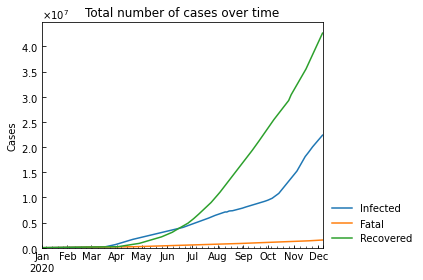

In [27]:
cs.line_plot(total_df[data_cols], "Total number of cases over time")

Based on the table above we are capable to illustrate the diagram for total cases by using line_plot.

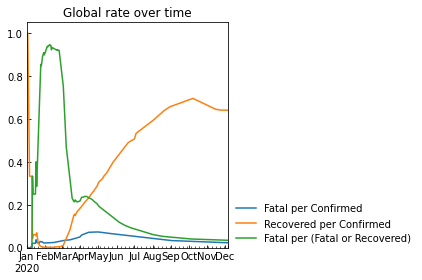

In [125]:
cs.line_plot(total_df[rate_cols], "Global rate over time", ylabel="", math_scale=False)

we can estimate of the rates.

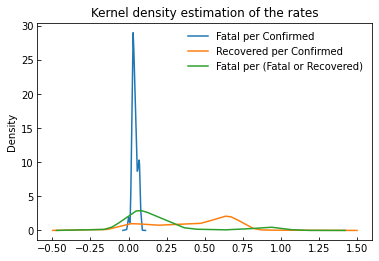

In [30]:
total_df[rate_cols].plot.kde()
plt.title("Kernel density estimation of the rates")
plt.show()

It’s possible to find the min, max and mean of the figure above. 

In [31]:
total_df[rate_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Fatal per Confirmed,340.0,0.039507,0.017391,0.000000,0.026947,0.034553,0.051113,0.074217
Recovered per Confirmed,340.0,0.419468,0.252857,0.001148,0.198071,0.495616,0.646716,1.000000
Fatal per (Fatal or Recovered),340.0,0.213381,0.275036,0.000000,0.043026,0.089423,0.229565,0.947644


we can implement the code to calculate the growth factor based on formula.

In [176]:
covid_df = jhu_data.cleaned()
df = covid_df.pivot_table(
    index="Date", columns="Country", values="Confirmed", aggfunc="sum"
).fillna(method="ffill").fillna(0)
# Growth factor: (delta Number_n) / (delta Number_n)
df = df.diff() / df.diff().shift(freq="D")
df = df.replace(np.inf, np.nan).fillna(1.0)
# Rolling mean (window: 7 days)
df = df.rolling(7).mean().dropna().loc[:covid_df["Date"].max(), :]
# round: 0.01
growth_value_df = df.round(2)
growth_value_df.tail()

Country,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,"Virgin Islands, U.S.",Western Sahara,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-02,1.11,1.06,0.99,1.0,0.85,1.32,1.00,1.00,1.13,1.09,...,1.10,0.95,1.0,1.12,1.26,1.55,1.0,1.32,1.12,0.77
2020-12-03,1.05,1.07,0.96,1.0,0.82,1.23,0.86,0.99,1.11,1.16,...,1.11,1.07,1.0,1.10,1.03,1.41,1.0,1.29,1.20,0.77
2020-12-04,0.97,1.07,0.96,1.0,0.84,1.55,1.00,1.00,1.13,1.06,...,1.07,1.47,1.0,1.08,0.92,1.41,1.0,1.35,1.68,0.71
2020-12-05,0.97,1.10,0.96,1.0,0.98,1.47,1.00,0.99,1.16,1.01,...,1.04,1.19,1.0,1.10,1.03,1.38,1.0,1.39,1.55,0.63
2020-12-06,0.65,0.89,0.82,1.0,0.83,1.44,1.00,0.87,1.03,0.92,...,0.90,1.22,1.0,0.93,0.88,1.33,1.0,1.18,1.41,0.63


Now we can categorize the countries. Firlsty we will sort them as follows: 

In [177]:
df = growth_value_df.copy()
df = df.iloc[-7:, :].T
day_cols = df.columns.strftime("%d%b%Y")
df.columns = day_cols
last_date = day_cols[-1]
# Grouping
more_col, less_col = "GF > 1 [straight days]", "GF < 1 [straight days]"
df[more_col] = (growth_value_df > 1).iloc[::-1].cumprod().sum(axis=0)
df[less_col] = (growth_value_df < 1).iloc[::-1].cumprod().sum(axis=0)
df["Group"] = df[[more_col, less_col]].apply(
    lambda x: "Outbreaking" if x[0] >= 7 else "Stopping" if x[1] >= 7 else "Crossroad",
    axis=1
)
# Sorting
df = df.loc[:, ["Group", more_col, less_col, *day_cols]]
df = df.sort_values(["Group", more_col, less_col], ascending=False)
growth_df = df.copy()
growth_df.head()

Date,Group,GF > 1 [straight days],GF < 1 [straight days],30Nov2020,01Dec2020,02Dec2020,03Dec2020,04Dec2020,05Dec2020,06Dec2020
Country,,,,,,,,,,
Gabon,Stopping,0,140,0.57,0.57,0.57,0.57,0.57,0.57,0.57
Benin,Stopping,0,121,0.86,0.71,0.71,0.71,0.71,0.71,0.71
Oman,Stopping,0,102,0.72,0.74,0.91,0.87,0.73,0.73,0.73
Equatorial Guinea,Stopping,0,78,0.57,0.71,0.57,0.57,0.57,0.57,0.71
Costa Rica,Stopping,0,70,0.83,0.82,0.92,0.93,0.92,0.92,0.92


Now we merge the data to categorize conutries as follows: 

In [178]:
df = pd.merge(covid_df, growth_df["Group"].reset_index(), on="Country")
covid_df = df.loc[:, ["Date", "Group", *covid_df.columns[1:]]]
covid_df.tail()

,Date,Group,Country,Province,Confirmed,Infected,Fatal,Recovered
351907,2020-12-02,Stopping,Zimbabwe,-,10129,1209,277,8643
351908,2020-12-03,Stopping,Zimbabwe,-,10424,1390,280,8754
351909,2020-12-04,Stopping,Zimbabwe,-,10547,1464,281,8802
351910,2020-12-05,Stopping,Zimbabwe,-,10617,1482,291,8844
351911,2020-12-06,Stopping,Zimbabwe,-,10617,1482,291,8844


In this group, the amount of confirmed cases are increasing rapidly. The list of countries is as follows:

In [130]:
df = growth_df.loc[growth_df["Group"] == "Outbreaking", :]
", ".join(df.index.tolist()) + "."

"Moldova, Belgium, Slovakia, Spain, Bulgaria, Israel, Haiti, Rwanda, North Macedonia, Singapore, Cape Verde, Estonia, Latvia, Senegal, Dominican Republic, Slovenia, Brazil, Guatemala, Mauritania, Namibia, Czech Republic, Swaziland, Armenia, Puerto Rico, New Zealand, Djibouti, Yemen, Mozambique, Bolivia, Monaco, Nigeria, France, Japan, Zambia, Cote d'Ivoire, Taiwan, Bermuda, Gambia."

The table for these countries is as follows: 

In [36]:
growth_df.loc[growth_df["Group"] == "Outbreaking", :].head(10)

Date,Group,GF > 1 [straight days],GF < 1 [straight days],30Nov2020,01Dec2020,02Dec2020,03Dec2020,04Dec2020,05Dec2020,06Dec2020
Country,,,,,,,,,,
Moldova,Outbreaking,165,0,1.14,1.40,1.38,1.37,1.39,1.35,1.26
Belgium,Outbreaking,150,0,1.50,1.51,1.52,1.51,1.43,1.38,1.30
Slovakia,Outbreaking,133,0,1.42,1.70,1.68,1.67,1.69,1.71,1.60
Spain,Outbreaking,126,0,1.60,1.59,1.60,1.57,1.56,1.51,1.56
Bulgaria,Outbreaking,70,0,1.27,1.25,1.26,1.27,1.29,1.30,1.24
Israel,Outbreaking,55,0,1.10,1.10,1.11,1.10,1.03,1.31,1.05
Haiti,Outbreaking,53,0,1.53,1.52,1.34,1.42,1.30,1.45,1.35
Rwanda,Outbreaking,50,0,1.04,1.12,1.42,1.11,1.34,1.39,1.18
North Macedonia,Outbreaking,47,0,1.13,1.20,1.15,1.23,1.21,1.20,1.09


Based on the data derived from the table we are capable to visuallize the group 1 countries: 

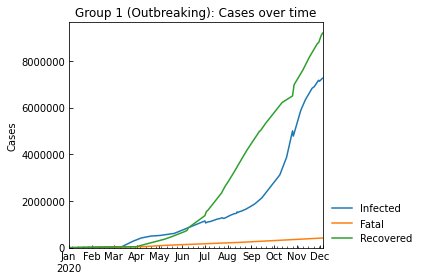

In [37]:
df = covid_df.loc[covid_df["Group"] == "Outbreaking", ["Date", *data_cols]]
df = df.groupby("Date").sum()
df = df.iloc[:-1, :]
if not df.empty:
    cs.line_plot(df, "Group 1 (Outbreaking): Cases over time", y_integer=True)
    df.tail()

Group 2: Stopping, the growth factor < 1 for the last 7 days
In this group the amount of confirmed cases are decreasing. The list of countries is as follows: 

In [38]:
df = growth_df.loc[growth_df["Group"] == "Stopping", :]
", ".join(df.index.tolist()) + "."


'Gabon, Benin, Oman, Equatorial Guinea, Costa Rica, El Salvador, Botswana, Luxembourg, San Marino, Comoros, Seychelles, Nicaragua, Papua New Guinea, Libya, Central African Republic, Somalia, Guinea-Bissau, Liberia, Italy, Sudan, Brunei, Fiji, India, Nepal, Kosovo, Andorra, Bahamas, Honduras, Lesotho, Saint Vincent and the Grenadines, Bhutan, Malawi, Austria, Zimbabwe.'

The table for these countries is as follows:

In [39]:
growth_df.loc[growth_df["Group"] == "Stopping", :].head(10)

Date,Group,GF > 1 [straight days],GF < 1 [straight days],30Nov2020,01Dec2020,02Dec2020,03Dec2020,04Dec2020,05Dec2020,06Dec2020
Country,,,,,,,,,,
Gabon,Stopping,0,140,0.57,0.57,0.57,0.57,0.57,0.57,0.57
Benin,Stopping,0,121,0.86,0.71,0.71,0.71,0.71,0.71,0.71
Oman,Stopping,0,102,0.72,0.74,0.91,0.87,0.73,0.73,0.73
Equatorial Guinea,Stopping,0,78,0.57,0.71,0.57,0.57,0.57,0.57,0.71
Costa Rica,Stopping,0,70,0.83,0.82,0.92,0.93,0.92,0.92,0.92
El Salvador,Stopping,0,59,0.71,0.71,0.71,0.71,0.71,0.71,0.71
Botswana,Stopping,0,38,0.71,0.71,0.71,0.71,0.71,0.71,0.71
Luxembourg,Stopping,0,34,0.84,0.85,0.83,0.78,0.82,0.82,0.82
San Marino,Stopping,0,32,0.71,0.92,0.91,0.97,0.93,0.93,0.93


Based on the data derived from the table we are capable to visuallize the group 2 countries. 

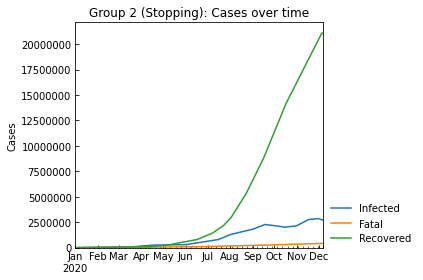

In [40]:
df = covid_df.loc[covid_df["Group"] == "Stopping", ["Date", *data_cols]].groupby("Date").sum()
if not df.empty:
    cs.line_plot(df, "Group 2 (Stopping): Cases over time", y_integer=True)
    df.tail()

Group 3: At a crossroad, the others countries belong to this group are somewhere in between of two previous groups. The confirmed cases is increasing in them and the recovered cases also increasing.
List of the countries is as follows: 

In [41]:
df = growth_df.loc[growth_df["Group"] == "Crossroad", :]
", ".join(df.index.tolist()) + "."

'Angola, Cyprus, Mali, Virgin Islands, U.S., Guyana, South Sudan, Uzbekistan, Chad, Burkina Faso, Croatia, Liechtenstein, Mauritius, Eritrea, Algeria, Belize, Burundi, Ghana, Kyrgyzstan, Northern Mariana Islands, Suriname, Tunisia, Cameroon, Lithuania, Saint Lucia, Saudi Arabia, United Kingdom, Sao Tome and Principe, Timor-Leste, Afghanistan, Iceland, Iran, Madagascar, Sweden, Argentina, Guam, Lebanon, Mongolia, Montenegro, Norway, Peru, Portugal, Qatar, Switzerland, Togo, Ukraine, Albania, Australia, Azerbaijan, Bahrain, Bangladesh, Barbados, Belarus, Bosnia and Herzegovina, Cambodia, Canada, Chile, China, Colombia, Cuba, Democratic Republic of the Congo, Denmark, Ecuador, Egypt, Ethiopia, Finland, Georgia, Germany, Greece, Guinea, Hungary, Indonesia, Iraq, Ireland, Jamaica, Jordan, Kazakhstan, Kenya, Kuwait, Malaysia, Maldives, Malta, Mexico, Morocco, Myanmar, Netherlands, Niger, Pakistan, Palestine, Panama, Paraguay, Philippines, Poland, Romania, Russia, Saint Kitts and Nevis, Serbi

Ukraine belongs to this group. The table for these countries is as follows: 

In [42]:
growth_df.loc[growth_df["Group"] == "Crossroad", :].head(10)

Date,Group,GF > 1 [straight days],GF < 1 [straight days],30Nov2020,01Dec2020,02Dec2020,03Dec2020,04Dec2020,05Dec2020,06Dec2020
Country,,,,,,,,,,
Angola,Crossroad,6,0,1.00,1.33,1.32,1.23,1.55,1.47,1.44
Cyprus,Crossroad,6,0,0.96,1.09,1.08,1.13,1.04,1.11,1.02
Mali,Crossroad,6,0,0.96,1.12,1.25,1.19,1.18,1.28,1.23
"Virgin Islands, U.S.",Crossroad,5,0,1.15,0.62,1.55,1.41,1.41,1.38,1.33
Guyana,Crossroad,4,0,1.10,0.94,0.97,1.28,1.29,1.24,1.05
South Sudan,Crossroad,4,0,0.62,0.62,0.98,1.61,1.52,1.66,1.52
Uzbekistan,Crossroad,4,0,1.14,1.07,0.95,1.07,1.47,1.19,1.22
Chad,Crossroad,3,0,1.26,1.52,0.72,0.67,1.14,1.18,1.04
Burkina Faso,Crossroad,2,0,1.37,1.56,0.86,0.95,0.89,1.21,1.07


Based on the data derived from the table we are capable to visuallize the group 3 countries. 

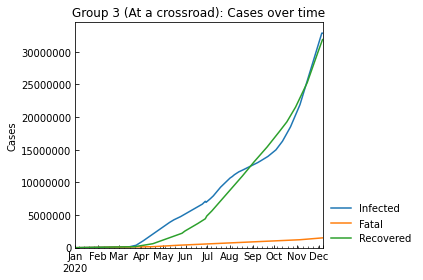

,Infected,Fatal,Recovered
Date,,,
2020-12-02,31635736,1468910,30755559
2020-12-03,32056396,1481541,31143265
2020-12-04,32520225,1493766,31479693
2020-12-05,32860181,1504163,31874838
2020-12-06,32860911,1504183,31874924


In [43]:
df = covid_df.loc[covid_df["Group"] == "Crossroad", ["Date", *data_cols]].groupby("Date").sum()
cs.line_plot(df, "Group 3 (At a crossroad): Cases over time", y_integer=True)
df.tail()

Here we can make the first title row of prefered table based on SIRF model

In [44]:
# Set tau value and start date of records
# For explanation, the start date will be 01Jan2020
# This is not based on actual data
example_data = cs.ExampleData(tau=1440, start_date="01Jan2020")
# No records has been registered
example_data.cleaned()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered


In [51]:
# Model name
print(cs.SIRF.NAME)
# Example parameter values
pprint(cs.SIRF.EXAMPLE, compact=True)

SIR-F
{'param_dict': {'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075, 'theta': 0.002},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 999000}}


Based on SIR-F model that we made now we can visualize the data

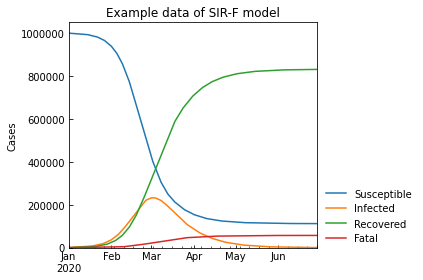

In [52]:
model = cs.SIRF
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

There is an inflection point of y (the number of currentrly infected cases per total population). At this point, the value of x (the number of susceptible cases per total population) is nearly equal to 1/R0. 

In [53]:
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE["param_dict"]).calc_r0()
df = example_data.specialized(model, **area)
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]
(x_max, 1/eg_r0)

(0.401442, 0.4)

Here, we will estimate the (θ,κ,ρ,σ) values of the example data using the hyperparameter optimization method by Optuna package. τ will be fixed as 1440 [min]. 

In [54]:
# Set population value
population_data.update(cs.SIRF.EXAMPLE["population"], **area)
population_data.value(**area)

1000000

we implement the code to make the diagram based on our variables.

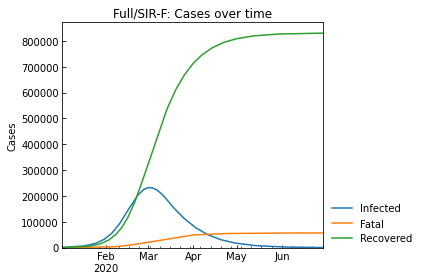

In [55]:
# Show records in JHU-style
sirf_snl = cs.Scenario(example_data, population_data, tau=1440, **area)
_ = sirf_snl.records()

We estimate the parameter using .estimate method.

In [56]:
# Set phases (phase: explained in "S-R trend analysis section")
# Records at 01Jan2020 will be removed because Recovered = 0
sirf_snl.clear(include_past=True)
sirf_snl.add().summary()

,Type,Start,End,Population,tau
0th,Past,02Jan2020,29Jun2020,1000000,1440


Trajectorie of parameter values in hyperparameter estimation are shown as follows:

In [57]:
# Parameter estimation
sirf_snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 8 CPUs...
Completed optimization. Total: 3 min  4 sec


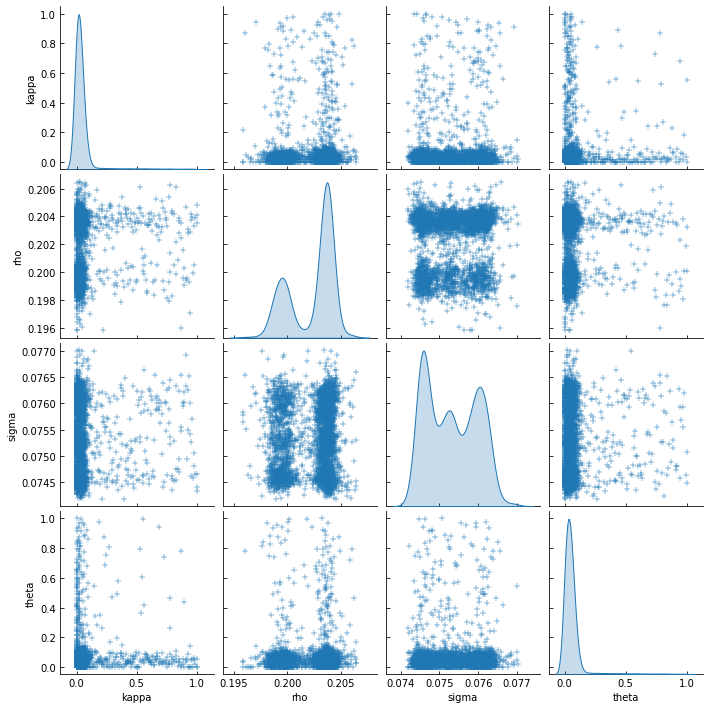

In [124]:
sirf_snl.estimate_history("0th")

Estimated parameter values are shown as follows: 

In [59]:
df = sirf_snl.summary()
setting_model = cs.SIRF(population=cs.SIRF.EXAMPLE["population"], **cs.SIRF.EXAMPLE["param_dict"])
setting_dict = {
    "Population": cs.SIRF.EXAMPLE["population"],
    "ODE": cs.SIRF.NAME,
    "Rt": setting_model.calc_r0(),
    "tau": 1440,
    **setting_model.calc_days_dict(1440),
    **cs.SIRF.EXAMPLE["param_dict"]
}
df = df.append(pd.Series(setting_dict, name="setting"))
df.fillna("-")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/beta [day],1/gamma [day],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,02Jan2020,29Jun2020,1000000,SIR-F,2.56,0.019557,0.003262,0.203457,0.074732,1440,0.020,4,13,306,0.0972948,3097,3 min 0 sec
setting,-,-,-,1000000,SIR-F,2.50,0.002000,0.005000,0.200000,0.075000,1440,0.002,5,13,200,-,-,-


Comparison of observed values and estimated values are shown as follows. 

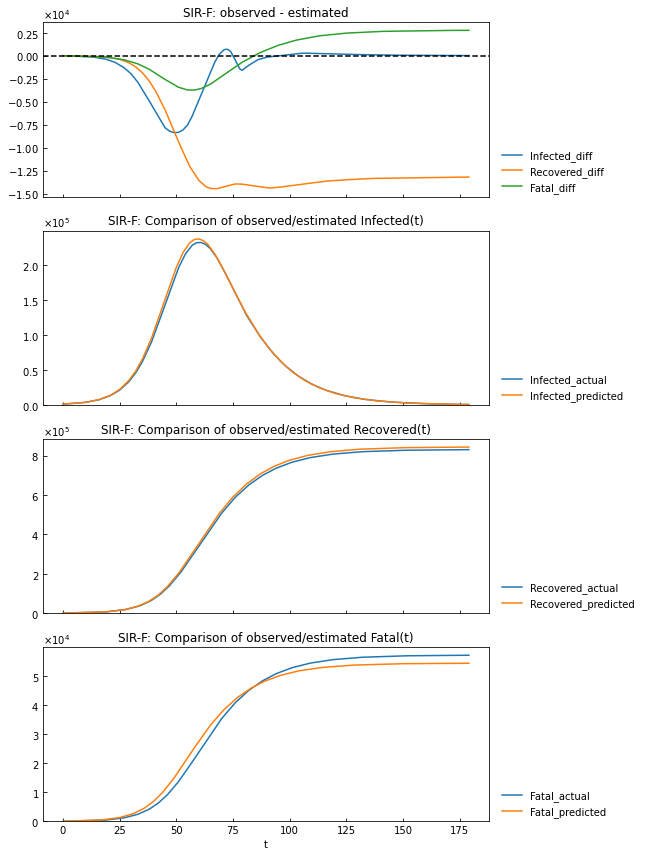

In [60]:
sirf_snl.estimate_accuracy("0th")

We will perform S-R trend analysis for actual data in Ukraine as an example.

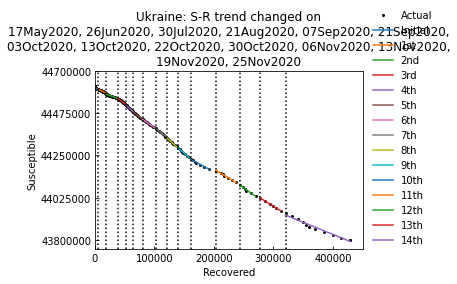

In [101]:
ita_scenario = cs.Scenario(jhu_data, population_data, "Ukraine")
_ = ita_scenario.trend()

In this section, we will perform scenario analysis using the records of Ukraine. 

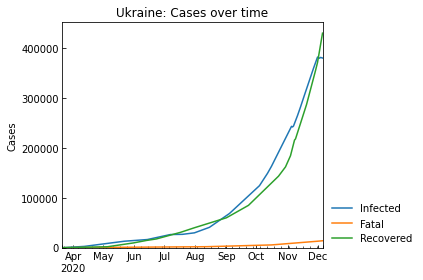

,Date,Confirmed,Infected,Fatal,Recovered
256,2020-12-02,778560,380459,13140,384961
257,2020-12-03,793372,379227,13394,400751
258,2020-12-04,808828,380840,13641,414347
259,2020-12-05,822985,379653,13877,429455
260,2020-12-06,822985,379653,13877,429455


In [102]:
ita_scenario = cs.Scenario(jhu_data, population_data, "Ukraine")
ita_scenario.records().tail()

We will use the change points as the start date of phases. For each phase, will apply SIR-F model. τ values will be the same value.

In [104]:
ita_scenario.summary()

,Type,Start,End,Population
0th,Past,21Mar2020,16May2020,44622516
1st,Past,17May2020,25Jun2020,44622516
2nd,Past,26Jun2020,29Jul2020,44622516
3rd,Past,30Jul2020,20Aug2020,44622516
4th,Past,21Aug2020,06Sep2020,44622516
5th,Past,07Sep2020,20Sep2020,44622516
6th,Past,21Sep2020,02Oct2020,44622516
7th,Past,03Oct2020,12Oct2020,44622516
8th,Past,13Oct2020,21Oct2020,44622516
9th,Past,22Oct2020,29Oct2020,44622516


We estimate parameters for implementing SIR-F model in Ukraine dataset

In [105]:
ita_scenario.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 8 CPUs...
	 3rd phase (30Oct2020 - 05Nov2020): finished 2819 trials in 3 min  0 sec
Completed optimization. Total: 6 min 48 sec


We compare parameters via table.

In [106]:
ita_scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/gamma [day],1/beta [day],1/alpha2 [day],alpha1 [-],RMSLE,Trials,Runtime
0th,Past,21Mar2020,16May2020,44622516,SIR-F,9.38,0.053485,0.000306,0.118545,0.011660,1440,85,8,3269,0.053,1.113574,2335,3 min 0 sec
1st,Past,17May2020,25Jun2020,44622516,SIR-F,1.42,0.018904,0.000331,0.033987,0.023179,1440,43,29,3020,0.019,0.041658,2414,3 min 1 sec
2nd,Past,26Jun2020,29Jul2020,44622516,SIR-F,1.40,0.000030,0.000742,0.031474,0.021714,1440,46,31,1348,0.000,0.036582,2536,3 min 0 sec
3rd,Past,30Jul2020,20Aug2020,44622516,SIR-F,2.13,0.000950,0.000642,0.039359,0.017855,1440,56,25,1557,0.001,0.011399,2605,3 min 0 sec
4th,Past,21Aug2020,06Sep2020,44622516,SIR-F,2.96,0.016276,0.000040,0.039649,0.013148,1440,76,25,25202,0.016,0.007697,589,0 min 40 sec
5th,Past,07Sep2020,20Sep2020,44622516,SIR-F,2.31,0.000653,0.000641,0.034232,0.014180,1440,70,29,1560,0.001,0.006341,461,0 min 30 sec
6th,Past,21Sep2020,02Oct2020,44622516,SIR-F,1.91,0.000632,0.000594,0.033945,0.017168,1440,58,29,1683,0.001,0.008020,430,0 min 30 sec
7th,Past,03Oct2020,12Oct2020,44622516,SIR-F,2.42,0.000116,0.000555,0.035225,0.013983,1440,71,28,1802,0.000,0.008084,1138,1 min 20 sec
8th,Past,13Oct2020,21Oct2020,44622516,SIR-F,2.63,0.000143,0.000645,0.033013,0.011887,1440,84,30,1551,0.000,0.008609,441,0 min 30 sec
9th,Past,22Oct2020,29Oct2020,44622516,SIR-F,2.33,0.000488,0.000526,0.033804,0.013963,1440,71,29,1901,0.000,0.011670,168,0 min 10 sec


We execute the code to illustrate the comparison in the diagram.

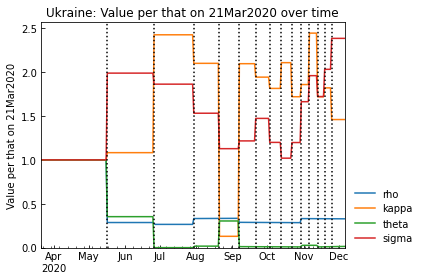

In [107]:
_ = ita_scenario.history_rate()

Measures taken in Ukraine are shown as follows:

In [108]:
def _color(data_df):
    df = data_df.copy()
    df.loc[:, :] = str()
    df.iloc[[3, 6, 8], :] = "background-color: lightgreen"
    return df

ita_action_df.style.apply(_color, axis=None)

,Region,Start_date,End_date,Action,Detail,Number_of_people
0,-,2020-01-30 00:00:00,NaT,Restriction of entry,All flights to and from China have been suspended,-1
1,-,2020-02-03 00:00:00,NaT,Leave from epidemic area,Return of people present in countries at risk and return of foreign citizens to the countries of origin exposed to the risk,-1
2,-,2020-02-06 00:00:00,NaT,Control in the Airport,Airport monitoring and control for domestic and international flights,62000
3,-,2020-02-21 00:00:00,2020-02-21 00:00:00,Quaranteene,"Mandatory quarantine isolation for close contacts with a positive cases, and provides active surveillance with fiduciary home permanence for those who have been in risk areas in the last 14 days",-1
4,"Lombardia,Veneto",2020-02-23 00:00:00,NaT,containment and management the Italian infected areas,decree-law introducing urgent measures regarding the containment and management of the epidemiological emergency from COVID-2019.,53856‬
5,"Emilia Romagna,Friuli Venezia Giulia, Lombardia, Veneto, Piemonte e Liguria,",2020-02-25 00:00:00,NaT,containment and management the Italian infected areas,decree-law introducing urgent measures regarding the containment and management of the epidemiological emergency from COVID-2019.,37447171‬
6,All,2020-03-04 00:00:00,2020-03-15 00:00:00,Close school and university,relative decree-law containing further measures to combat and contain the spread of the COVID-19 virus throughout the country,8466064
7,"Emilia Romagna,Friuli Venezia Giulia, Lombardia, Veneto, Piemonte e Liguria,",2020-03-07 00:00:00,2020-03-07 00:00:00,more containment and management the Italian infected areas,"prohibit any movement in Lombardy and in fourteen provinces of Veneto, Emilia Romagna, Piedmont, Marche.",-1
8,-,2020-03-09 00:00:00,2020-05-04 00:00:00,lockdown,people must stay at home and go out only for food or work needs. Many activities are closed and only the essential ones remain open.,60483973
9,-,2020-03-19 00:00:00,NaT,Medicine sperimentation,"testing began on the drug Tocilizumab, a drug used against rheumatoid arthritis that has had beneficial effects against COVID-19 in China.",330


Here, we predict the effect of school closure, the lockdown on Apr 2020 with assumption that the effect will be shown from the start date of the 5rd phase. 

In [109]:
ita_scenario.get("Start", name="Main", phase="5th")

'07Sep2020'

We estimate average number peple go out using @marcoferrante estimation table and population pyramid data. It is necessary to replace the population pyramid data for Ukraine because the situation is different from the average data. 

In [110]:
c_before, c_after = 0.1, 0.81

In [111]:
ita_out_df = go_out("Ukraine")
ita_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Portion
0,0,2,nursery,3,0,0,0.029017
1,3,5,nursery school,4,0,1,0.030672
2,6,10,elementary school,5,0,1,0.056309
3,11,13,middle school,5,0,1,0.032996
4,14,18,high school,6,0,1,0.047233
5,19,25,university/work,3,3,1,0.070750
6,26,35,work,0,6,1,0.148973
7,36,45,work,0,5,1,0.156723
8,46,55,work,0,5,1,0.134502
9,56,65,work,0,5,1,0.135738


Predict the future with the last parameters in one week:

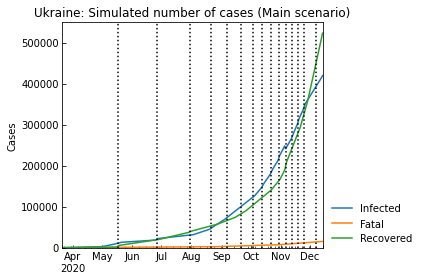

,Date,Confirmed,Fatal,Infected,Recovered
262,2020-12-08 00:00:00,864619,14150,395132,455337
263,2020-12-09 00:00:00,879794,14339,399081,466374
264,2020-12-10 00:00:00,895116,14530,403064,477522
265,2020-12-11 00:00:00,910584,14723,407081,488780
266,2020-12-12 00:00:00,926201,14918,411132,500151
267,2020-12-13 00:00:00,941968,15114,415219,511635
268,2020-12-14 00:00:00,957886,15313,419340,523233


In [116]:
ita_scenario.clear()
ita_scenario.add(days=7)
ita_scenario.simulate().tail(7).style.background_gradient(axis=0)

Predict the future with the last parameters in 60 days:

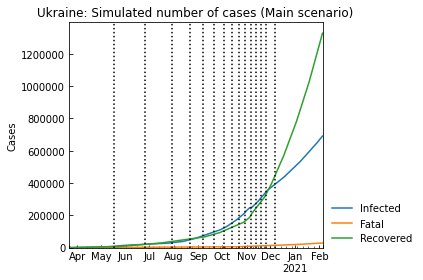

,Date,Confirmed,Fatal,Infected,Recovered
315,2021-01-30 00:00:00,1897917,27163,654987,1215767
316,2021-01-31 00:00:00,1922465,27476,660934,1234055
317,2021-02-01 00:00:00,1947219,27791,666920,1252508
318,2021-02-02 00:00:00,1972184,28110,672946,1271128
319,2021-02-03 00:00:00,1997358,28431,679011,1289916
320,2021-02-04 00:00:00,2022745,28755,685116,1308874
321,2021-02-05 00:00:00,2048344,29082,691261,1328001


In [117]:
ita_scenario.clear()
ita_scenario.add(days=60)
ita_scenario.simulate().tail(7).style.background_gradient(axis=0)

Predict the future with the last parameters in the long-term:

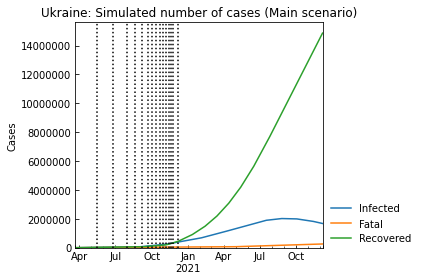

In [118]:
ita_scenario.clear()
ita_scenario.add(days=365)
_ = ita_scenario.simulate()

Effect of expected new medicines in 90 days:

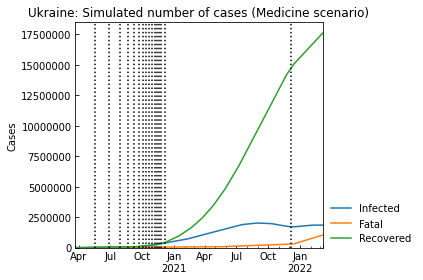

,Date,Confirmed,Fatal,Infected,Recovered
710,2022-03-01 00:00:00,20240421,974900,1856893,17408628
711,2022-03-02 00:00:00,20279930,983689,1856335,17439906
712,2022-03-03 00:00:00,20319362,992474,1855714,17471174
713,2022-03-04 00:00:00,20358718,1001257,1855030,17502431
714,2022-03-05 00:00:00,20397994,1010036,1854282,17533676
715,2022-03-06 00:00:00,20437190,1018811,1853471,17564908
716,2022-03-07 00:00:00,20476304,1027582,1852597,17596125


In [121]:
ita_scenario.add(days=90, name="Medicine", kappa=kappa_med, sigma=sigma_med)
ita_scenario.simulate(name="Medicine").tail(7).style.background_gradient(axis=0)

Effect of expected new medicines in long term:

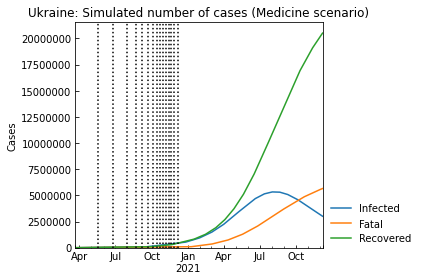

,Date,Confirmed,Fatal,Infected,Recovered
620,2021-12-01 00:00:00,28909145,5564328,3155342,20189475
621,2021-12-02 00:00:00,28952058,5579192,3130423,20242443
622,2021-12-03 00:00:00,28994541,5593938,3105614,20294989
623,2021-12-04 00:00:00,29036596,5608565,3080918,20347113
624,2021-12-05 00:00:00,29078233,5623075,3056339,20398819
625,2021-12-06 00:00:00,29119457,5637468,3031882,20450107
626,2021-12-07 00:00:00,29160277,5651744,3007553,20500980


In [179]:
ita_scenario.clear(name="Medicine")
ita_scenario.add(days=365, name="Medicine", kappa=kappa_med, sigma=sigma_med)
ita_scenario.simulate(name="Medicine").tail(7).style.background_gradient(axis=0)